# IOR benchmark

Results from IOR benchmark.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Benchmark tests

Currently the tests are provided for benchmarking read and write bandwidths of the parallel file systems for different types of I/O interfaces and file types. The supported I/O interfaces are

- POSIX IO
- MPI IO
- HDF5
 
Two different types of files are written namely

- Single file
- File per process

## Latest run performance metrics

All the performance metrics are tabulated from the latest benchmark run for different systems/parititons and programming environments

In [4]:
df = modules.utils.tabulate_last_perf(test='IorTest*',
                                     root=PERFLOG_DIR,
                                     extras=['num_nodes', 'io_type', 'file_type'])
df = df.transpose() # so now cols are all, single
df = df.sort_values(['case'])
display(df)

perf_var                                                                  read_bw  \
case                                        num_nodes io_type file_type             
juwels-cluster:batch-gcc9-ompi4-ib-umod:ior 4         hdf5    fpp         8573.85   
                                                              single       723.64   
                                                      mpiio   fpp         7683.75   
                                                              single       797.21   
                                                      posix   fpp        11882.65   
                                                              single      7329.30   

perf_var                                                                 write_bw  
case                                        num_nodes io_type file_type            
juwels-cluster:batch-gcc9-ompi4-ib-umod:ior 4         hdf5    fpp         6408.57  
                                                              single      1104.36  
                                                      mpiio   fpp         6250.45  
                                                              single      1385.69  
                                                      posix   fpp         4652.73  
                                                              single      6839.43

## Performance History

The plot shows the **Read** bandwidths for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

In [5]:
def plot_perf_history(var, perf_records):
    for (io, file_type) in [('hdf5', 'single'),
                        ('hdf5', 'fpp'),
                        ('mpiio', 'single'),
                        ('mpiio', 'fpp'),
                        ('posix', 'single'), 
                        ('posix', 'fpp')]:
        if perf_records is None:
            print('%s: no performance logs found' % test)
        else:
            fig, ax = plt.subplots(nrows=1, ncols=1)
            for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
                # filter to only Gflops records (might have others)
                data = data.loc[(data['perf_var'] == var) & (data['io_type'] == io) & (data['file_type'] == file_type)]
                data.plot(ax=ax, x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

                # annotate points with git_ref:
                for x, y, ref in zip(data['completion_time'], data['perf_value'], data['git']):
                    if not pd.isnull(ref):
                        ax.annotate(ref[:7], (x, y))
            ax.set_title(' '.join([io, file_type, 'Read BW']))
            ax.set_xlabel('completion time')
            ax.set_ylabel('MiB/s')
            handles, labels = ax.get_legend_handles_labels()
            ax.grid()
            fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

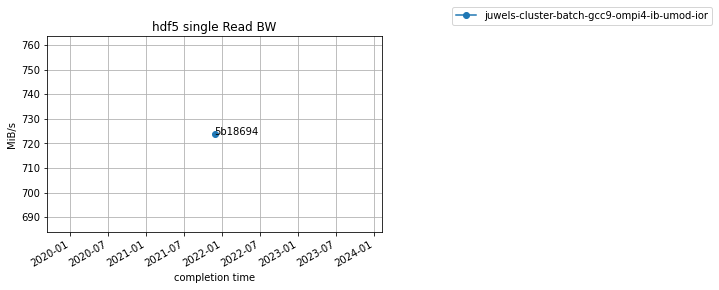

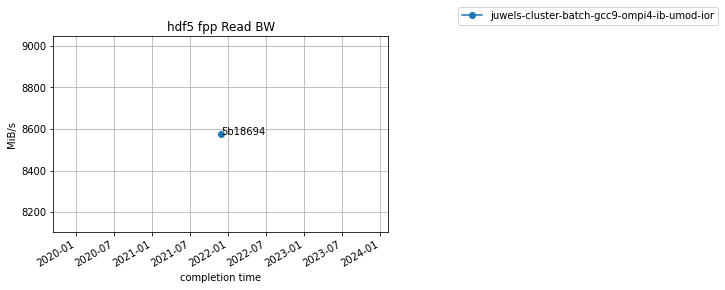

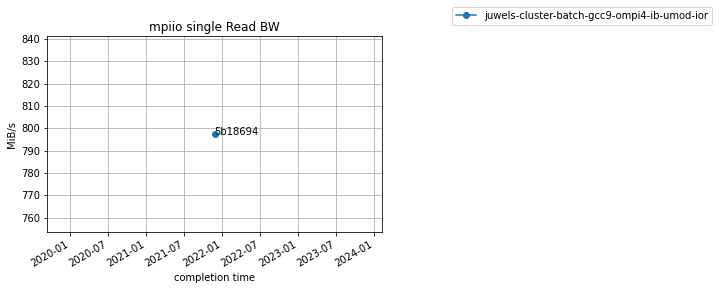

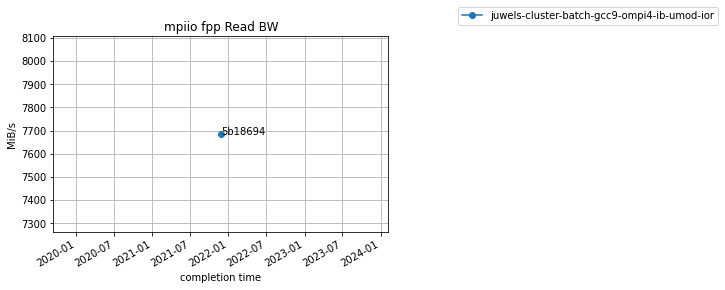

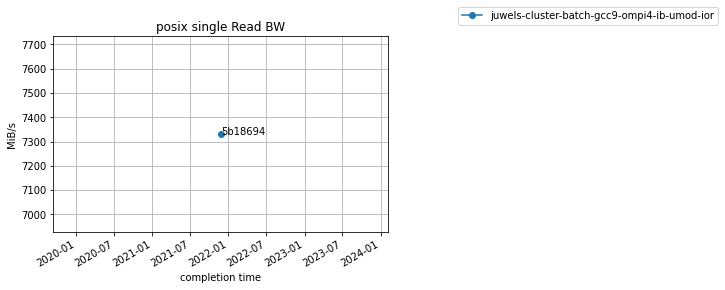

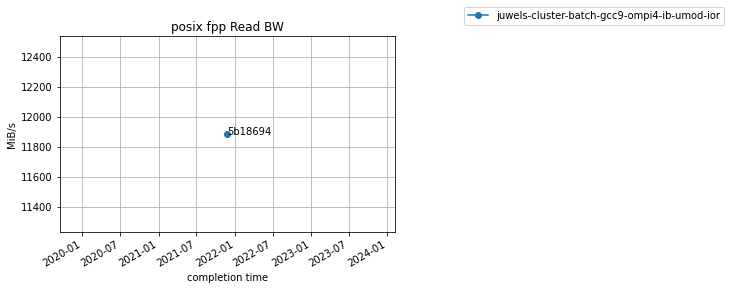

In [6]:
test='IorTest'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['num_nodes', 'io_type', 'file_type'], test=test)
plot_perf_history('read_bw', perf_records)

The plot shows the **Write** bandwidths for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

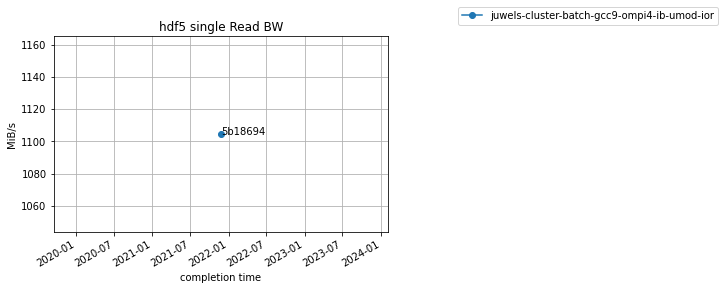

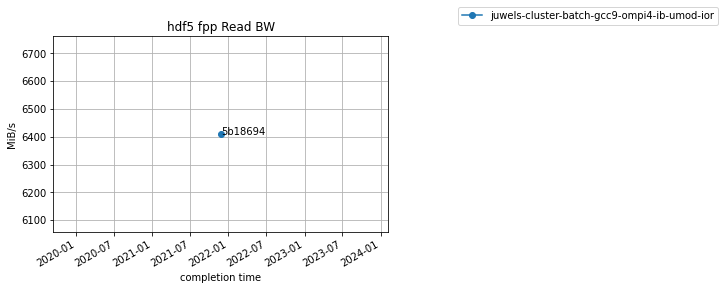

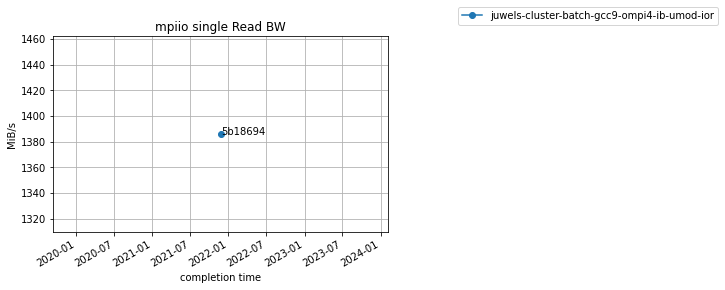

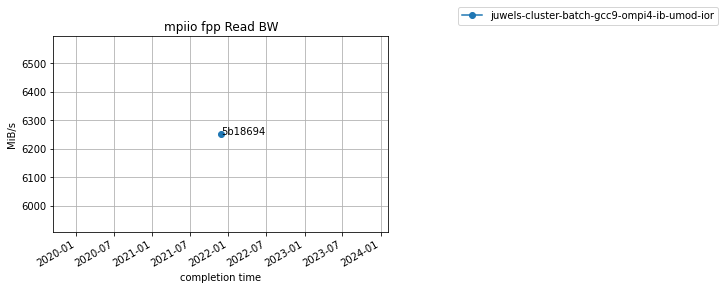

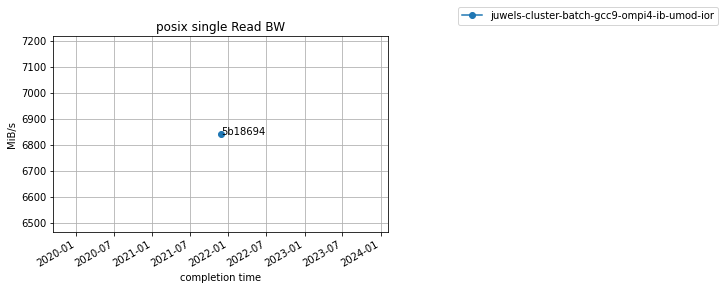

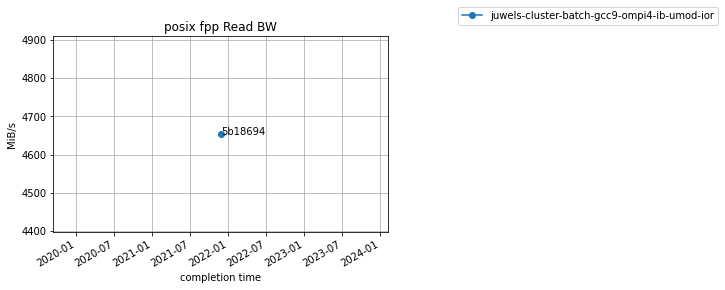

In [7]:
test='IorTest'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=['num_nodes', 'io_type', 'file_type'], test=test)
plot_perf_history('write_bw', perf_records)